<a href="https://colab.research.google.com/github/anuva05/PracticalDeepLearningCourse/blob/master/Lesson3_satellite_images_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi-label prediction with the Planet Amazon dataset from Kaggle

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!curl -s https://course.fast.ai/setup/colab | bash
from fastai import *
from fastai.datasets import *
from fastai.vision import *


Updating fastai...
Done.


In [0]:
path = Config.data_path()
folder='planets'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)


Installing the Kaggle download tool..

In [0]:
 #!  pip install kaggle --upgrade

Downloaded a new API token from my Kaggle profile, and uploaded it to the environment in which this notebook is running. 

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/


Downloading the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). We **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data).

I found an alternate way to download the Planets dataset from Kaggle, as it was not longer available on the competition page.

In [5]:
## uncomment the following to download
! kaggle datasets download nikitarom/planets-dataset

 99% 1.48G/1.50G [00:19<00:00, 100MB/s] 
100% 1.50G/1.50G [00:19<00:00, 80.9MB/s]


In [6]:
## uncomment the following
! mv planets-dataset.zip {dest}
! ls {dest}

planets-dataset.zip


In [0]:
## uncomment the following
! unzip {dest}/planets-dataset.zip -d {dest}


In [8]:
folder = 'planet/planet'
path = dest/folder
path.ls()
#! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

[PosixPath('/root/.fastai/data/planets/planet/planet/train_classes.csv'),
 PosixPath('/root/.fastai/data/planets/planet/planet/train-jpg'),
 PosixPath('/root/.fastai/data/planets/planet/planet/sample_submission.csv'),
 PosixPath('/root/.fastai/data/planets/planet/planet/test-jpg')]

#Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_classes.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.
Since this data is in the form of tables, we will use Pandas to deal with it.

In [9]:
import pandas as pd

df = pd.read_csv(path/'train_classes.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.
The variable ```flip_vert```  is set to False by default. This makes sense for images of dogs and cats, since we would want to train on these images flipped from side to side, but can leave out vertically flipped images. In the case of satellite images, we will set ```flip_vert``` to True since we want the image of the earth from space to be analyzed from any angle that it is captured at. 

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

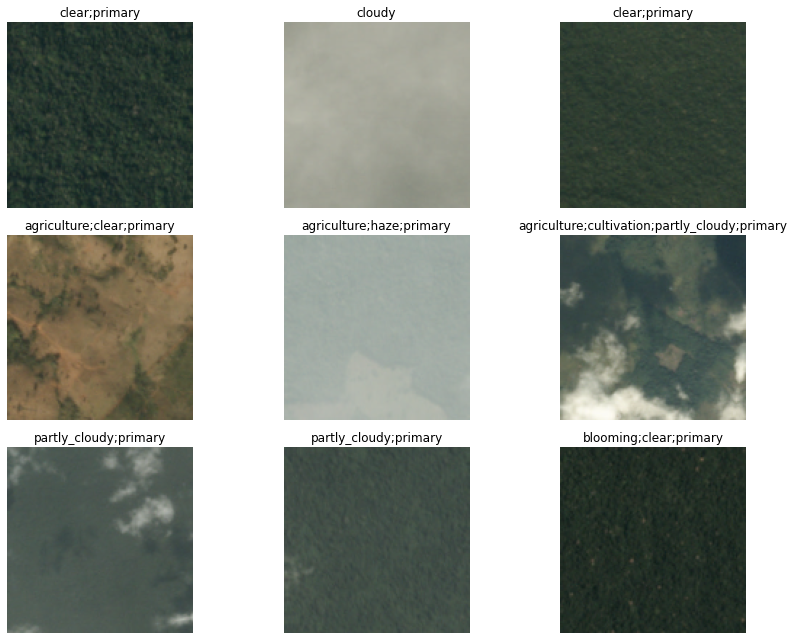

In [12]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

#using size 128
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))
#look at some images
data.show_batch(rows=3, figsize=(12,9))

**Creating a learner.** Our base architecture is resnet50 again, but the metrics are a little bit different: we use ```accuracy_thresh``` instead of ```accuracy```. This is because, in classification that involved picking a single output label for an image, we determined the predicition for a given class by picking the largest final activation. However, in multilabel classification, each activation can be 0. or 1. ```accuracy_thresh``` selects the outputs that are above a certain threshold (0.5 by default) and compares them to the ground truth.
Fbeta is also used because it is the metric that was used by Kaggle on this competition. 

In [0]:
arch = models.resnet50

In [14]:
#the following function uses the accuracy_thresh metric to select output if thresh>0.2
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


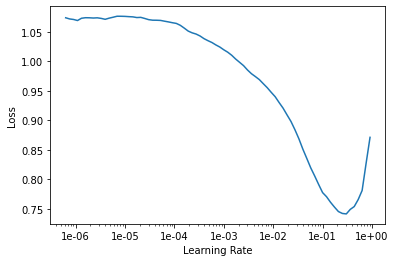

In [15]:
#Use the fast.ai learning rate finder to find a good learning rate
learn.lr_find()
learn.recorder.plot()

In the plot, we see that the loss is sharply increasing for learning rate value between 0.1 and 1. Hence, let us pick a learning rate=0.01 and fit our network.

In [17]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.136091,0.115764,0.946365,0.898797,03:02
1,0.113509,0.097891,0.948349,0.913019,03:02
2,0.101496,0.092997,0.954569,0.918981,03:01
3,0.093507,0.088577,0.955746,0.923181,03:02
4,0.091959,0.086714,0.956109,0.926085,03:08


In [0]:
learn.save('stage-1-rn50')

The accuracy here is 95.6% which tells us that we are on the right track. It is now time to fine-tune the model. In the previous training step, the model was frozen - this means the weights of the initial layers were frozen and only the last group/layer was trained. In order to fine-tune, we will unfreeze the model (this means, all weights from frozen layers of the model now can get updated from their pre-trained state according to the loss function), and choose a better learning rate before training again.

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


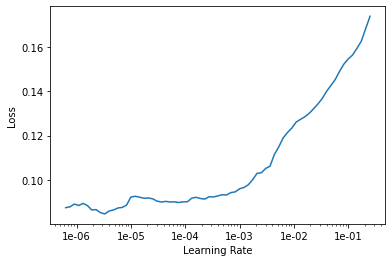

In [20]:
#Look at plot of loss vs. learning rate
learn.lr_find()
learn.recorder.plot()

In [21]:
#Fit the model again. We specify a range of learning rates to use.
#From the plot, we see that 1e-5 may be a good rate. For the upper bound (to 
# be used on the last layers), empirically select previous learning rate divided by 
# 5 or 10. 
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098492,0.092242,0.955194,0.920204,03:16
1,0.096119,0.090559,0.954423,0.920529,03:18
2,0.090271,0.087089,0.955892,0.925364,03:18
3,0.084086,0.083019,0.956858,0.927893,03:18
4,0.079306,0.082647,0.957970,0.928924,03:18


In [0]:
learn.save('stage-2-rn50')

# Using a dataset of larger images

We now have a model that is good at recognizing labels for 128 x 128 sized satellite images. Now, what if we have 256 x 256 sized images? Can we use the already trained model to predict labels here? The concept of transfer learning is useful here. The new dataset has images that are 4 times larger than the original. The learner is the same, and we won't be overfitting because the larger images form a whole new dataset. 

In [3]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

NameError: ignored

In [2]:
learn.freeze()

NameError: ignored

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#Referring to plot above, the following learning rate seems suitable.
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

In [0]:
learn.save('stage-1-256-rn50')

In [0]:
#Fine tuning...
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, lr/5))
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')